In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.utils import plot_accuracy_vs_metric
from src.metrics import (
    adaptive_calibration_error,
    brier_score,
    plot_calibration_curve)

In [2]:
graphics_format = ".pdf"
graphics_path = "/Users/christopher/Documents/University/Master/BEAR Confidence Estimation In LMs/Thesis/Graphics/"
tables_path = "/Users/christopher/Documents/University/Master/BEAR Confidence Estimation In LMs/Thesis/Tables/"
list_of_all_models = [x for x in os.listdir("../results/scores") if not x.startswith(".")]

# Experiment 2: Confidence Estimates Evaluation

### Long dataframe with instance-level predictions

In [3]:
instance_lvl_results = pd.read_json(
    "../results/instance_level_results.json",
    orient="records",
    lines=True
)

### Dataframe storing the estimators result per model for ACE and Brier Score

In [4]:
# For the correlation plot later
model_families = pd.DataFrame([
    ("bert-base-cased", "bert"),
    ("bert-large-cased", "bert"),
    ("gemma-2b", "gemma"),
    ("gemma-7b", "gemma"),
    ("gpt2", "gpt2"),
    ("gpt2-medium", "gpt2"),
    ("gpt2-large", "gpt2"),
    ("gpt2-xl", "gpt2"),
    ("opt-125m", "opt"),
    ("opt-350m", "opt"),
    ("opt-1.3b", "opt"),
    ("opt-6.7b", "opt"),
    ("roberta-base", "roberta"),
    ("roberta-large", "roberta"),
    ("xlm-roberta-base", "xlm-roberta"),
    ("xlm-roberta-large", "xlm-roberta")],
    columns=["model", "family"])

In [5]:
estimators = ["base_conf", "margin_conf", "average_conf_plurality", 
              "consistency_conf_plurality", "weighted_conf"]
evaluation_metrics_per_model = {
    "model": [],
    "estimator": [],
    "accuracy": [],
    "ace": [],
    "brier_score": []
}
models = instance_lvl_results["model"].unique()

for model in models:
    df_model = instance_lvl_results[instance_lvl_results["model"] == model]

    for estimator in estimators:

        if estimator in ["average_conf_plurality", "consistency_conf_plurality"]:
            preds = df_model["plurality_correct"]
            evaluation_metrics_per_model["accuracy"].append(df_model["plurality_correct"].mean())
        elif estimator == "weighted_conf":
            preds = df_model["max_conf_correct"]
            evaluation_metrics_per_model["accuracy"].append(df_model["max_conf_correct"].mean())
        else:
            preds = df_model["correctly_predicted"]
            evaluation_metrics_per_model["accuracy"].append(df_model["correctly_predicted"].mean())

        confs = df_model[estimator]

        ace = adaptive_calibration_error(preds, confs, n_bins=20)
        brier = brier_score(preds, confs)
        evaluation_metrics_per_model["model"].append(model)
        evaluation_metrics_per_model["estimator"].append(estimator)
        evaluation_metrics_per_model["ace"].append(ace)
        evaluation_metrics_per_model["brier_score"].append(brier)
    
    preds = df_model["correctly_predicted"]
    np.random.seed(444)
    confs = np.random.uniform(low=0, high=1, size=len(df_model))
    ace = adaptive_calibration_error(preds, confs, n_bins=20)
    brier = brier_score(preds, confs)
    evaluation_metrics_per_model["model"].append(model)
    evaluation_metrics_per_model["estimator"].append("random_baseline")
    evaluation_metrics_per_model["accuracy"].append(preds.mean())
    evaluation_metrics_per_model["ace"].append(ace)
    evaluation_metrics_per_model["brier_score"].append(brier)
results_evaluation = pd.DataFrame(evaluation_metrics_per_model).merge(
    model_families,
    on="model",
    how="inner")

### Table 5.2: Adaptive Calibration Error of continously distributed estimators

In [6]:
(
    results_evaluation
    .pivot_table(index="model", columns="estimator", values="ace")
    .round(3)
    .reindex(columns=["random_baseline", "base_conf", "margin_conf",
                      "average_conf_plurality", "consistency_conf_plurality", "weighted_conf"])
    .assign(row_min=lambda row: row.min(axis=1))
    .sort_values("row_min")
    .drop(columns="row_min")
    .to_latex(tables_path + "table_5_2.txt", float_format="%.3f", header=True)
)

### Table 5.3: Brier Score of the confidence estimates

In [7]:
(
    results_evaluation
    .query("estimator != 'random_baseline'")
    .pivot_table(index="model", columns="estimator", values="brier_score")
    .round(3)
    .reindex(columns=["base_conf", "margin_conf", "average_conf_plurality",
                      "consistency_conf_plurality", "weighted_conf"])
    .assign(row_min=lambda row: row.min(axis=1))
    .sort_values("row_min")
    .drop(columns="row_min")
    .to_latex(tables_path + "table_5_3.txt", float_format="%.3f", header=True)
)

### Figure 5.3: Calibration Curves for the smaller models

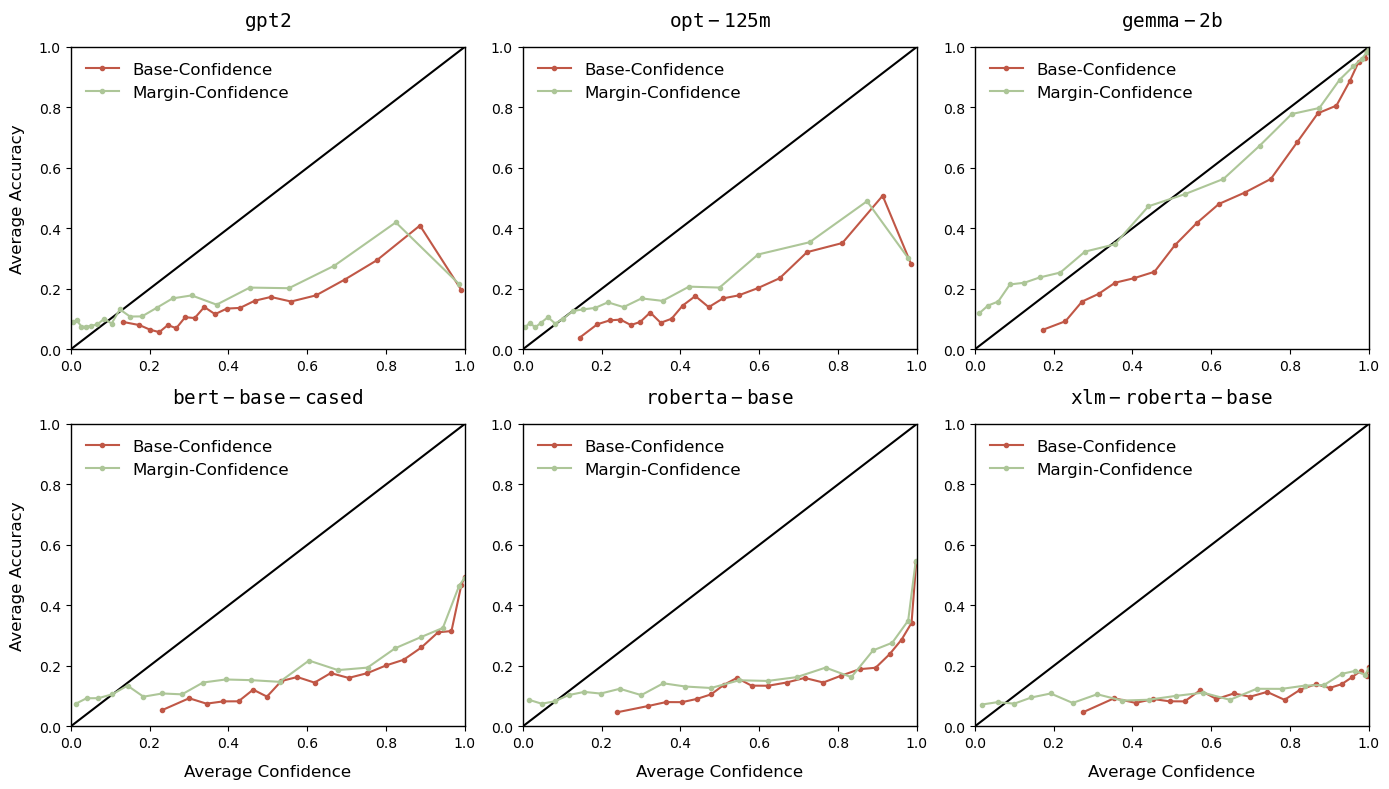

In [8]:
gemma_2b = instance_lvl_results[instance_lvl_results["model"] == "gemma-2b"]
gpt2 = instance_lvl_results[instance_lvl_results["model"] == "gpt2"]
opt125m = instance_lvl_results[instance_lvl_results["model"] == "opt-125m"]
bert_base = instance_lvl_results[instance_lvl_results["model"] == "bert-base-cased"]
roberta_base = instance_lvl_results[instance_lvl_results["model"] == "roberta-base"]
xlm_roberta_base = instance_lvl_results[instance_lvl_results["model"] == "xlm-roberta-base"]

models_info = [
    {
        "title": "gpt2",
        "df": gpt2,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 0, "col": 0
    },
    {
        "title": "opt-125m",
        "df": opt125m,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 0, "col": 1
    },
    {
        "title": "gemma-2b",
        "df": gemma_2b,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 0, "col": 2
    },
    {
        "title": "bert-base-cased",
        "df": bert_base,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 1, "col": 0
    },
    {
        "title": "roberta-base",
        "df": roberta_base,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 1, "col": 1
    },
    {
        "title": "xlm-roberta-base",
        "df": xlm_roberta_base,
        "pred_keys": ["correctly_predicted", "correctly_predicted"],
        "conf_keys": ["base_conf", "margin_conf"],
        "labels": ["Base-Confidence", "Margin-Confidence"],
        "row": 1, "col": 2
    },
]

_, axes = plt.subplots(2, 3, figsize=(14, 8), facecolor="white", sharey=True)

for info in models_info:
    ax = axes[info["row"], info["col"]]
    plot_calibration_curve(
        title=rf"$\mathtt{{{info['title']}}}$",
        predictions=[info["df"][k].tolist() for k in info["pred_keys"]],
        confidences=[info["df"][k].tolist() for k in info["conf_keys"]],
        labels=info["labels"],
        linestyles=["solid"]*2,
        markers=["."]*2,
        colors=["#c05746", "#adc698"],
        title_fontsize=14,
        legend_fontsize=12,
        axes_label_fontsize=12,
        axis=ax
    )
    if info["col"] > 0:
        ax.set_ylabel("")
    if info["row"] == 0:
        ax.set_xlabel("")
plt.tight_layout()
plt.savefig(graphics_path + "calibration_curves_small_models" + graphics_format, format="pdf")
plt.show()

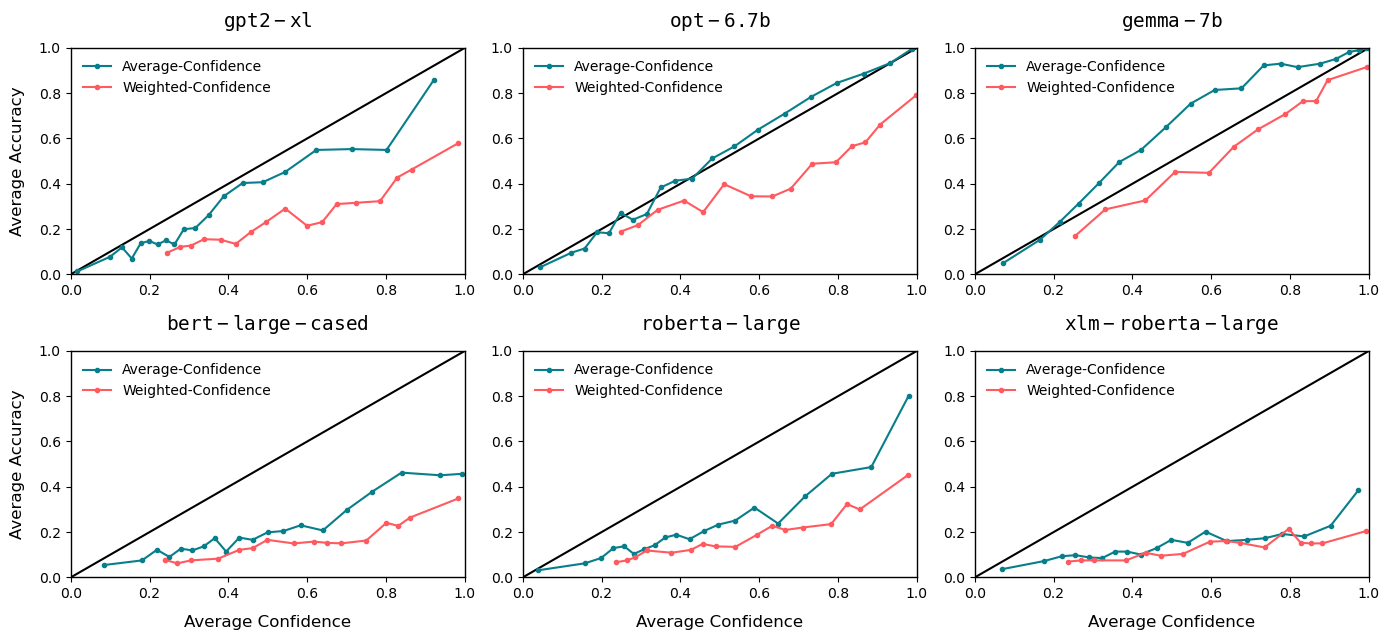

In [9]:
# Data for the larger models
gemma_7b = instance_lvl_results[instance_lvl_results["model"] == "gemma-7b"]
gpt2_xl = instance_lvl_results[instance_lvl_results["model"] == "gpt2-xl"]
opt67 = instance_lvl_results[instance_lvl_results["model"] == "opt-6.7b"]
bert_large = instance_lvl_results[instance_lvl_results["model"] == "bert-large-cased"]
roberta_large = instance_lvl_results[instance_lvl_results["model"] == "roberta-large"]
xlm_roberta_large = instance_lvl_results[instance_lvl_results["model"] == "xlm-roberta-large"]

models_info = [
    {
        "title": "gpt2-xl",
        "df": gpt2_xl,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 0, "col": 0
    },
    {
        "title": "opt-6.7b",
        "df": opt67,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 0, "col": 1
    },
    {
        "title": "gemma-7b",
        "df": gemma_7b,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 0, "col": 2
    },
    {
        "title": "bert-large-cased",
        "df": bert_large,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 1, "col": 0
    },
    {
        "title": "roberta-large",
        "df": roberta_large,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 1, "col": 1
    },
    {
        "title": "xlm-roberta-large",
        "df": xlm_roberta_large,
        "pred_keys": ["plurality_correct", "max_conf_correct"],
        "conf_keys": ["average_conf_plurality", "weighted_conf"],
        "labels": ["Average-Confidence", "Weighted-Confidence"],
        "row": 1, "col": 2
    },
]

_, axes = plt.subplots(2, 3, figsize=(14, 6.5), facecolor="white", sharey=True)

for info in models_info:
    ax = axes[info["row"], info["col"]]
    plot_calibration_curve(
        title=rf"$\mathtt{{{info['title']}}}$",
        predictions=[info["df"][k].tolist() for k in info["pred_keys"]],
        confidences=[info["df"][k].tolist() for k in info["conf_keys"]],
        labels=info["labels"],
        linestyles=["solid"]*2,
        markers=["."]*2,
        colors=["#087e8b", "#ff5a5f"],
        title_fontsize=14,
        legend_fontsize=10,
        axes_label_fontsize=12,
        axis=ax,
        n_bins=20
    )
    if info["col"] > 0:
        ax.set_ylabel("")
    if info["row"] == 0:
        ax.set_xlabel("")

plt.tight_layout()
plt.savefig(graphics_path + "calibration_curves_large_models" + graphics_format, format="pdf")
plt.show()

### Figure 5.5: Correlations between Accuracy and Adaptive Calibration Error

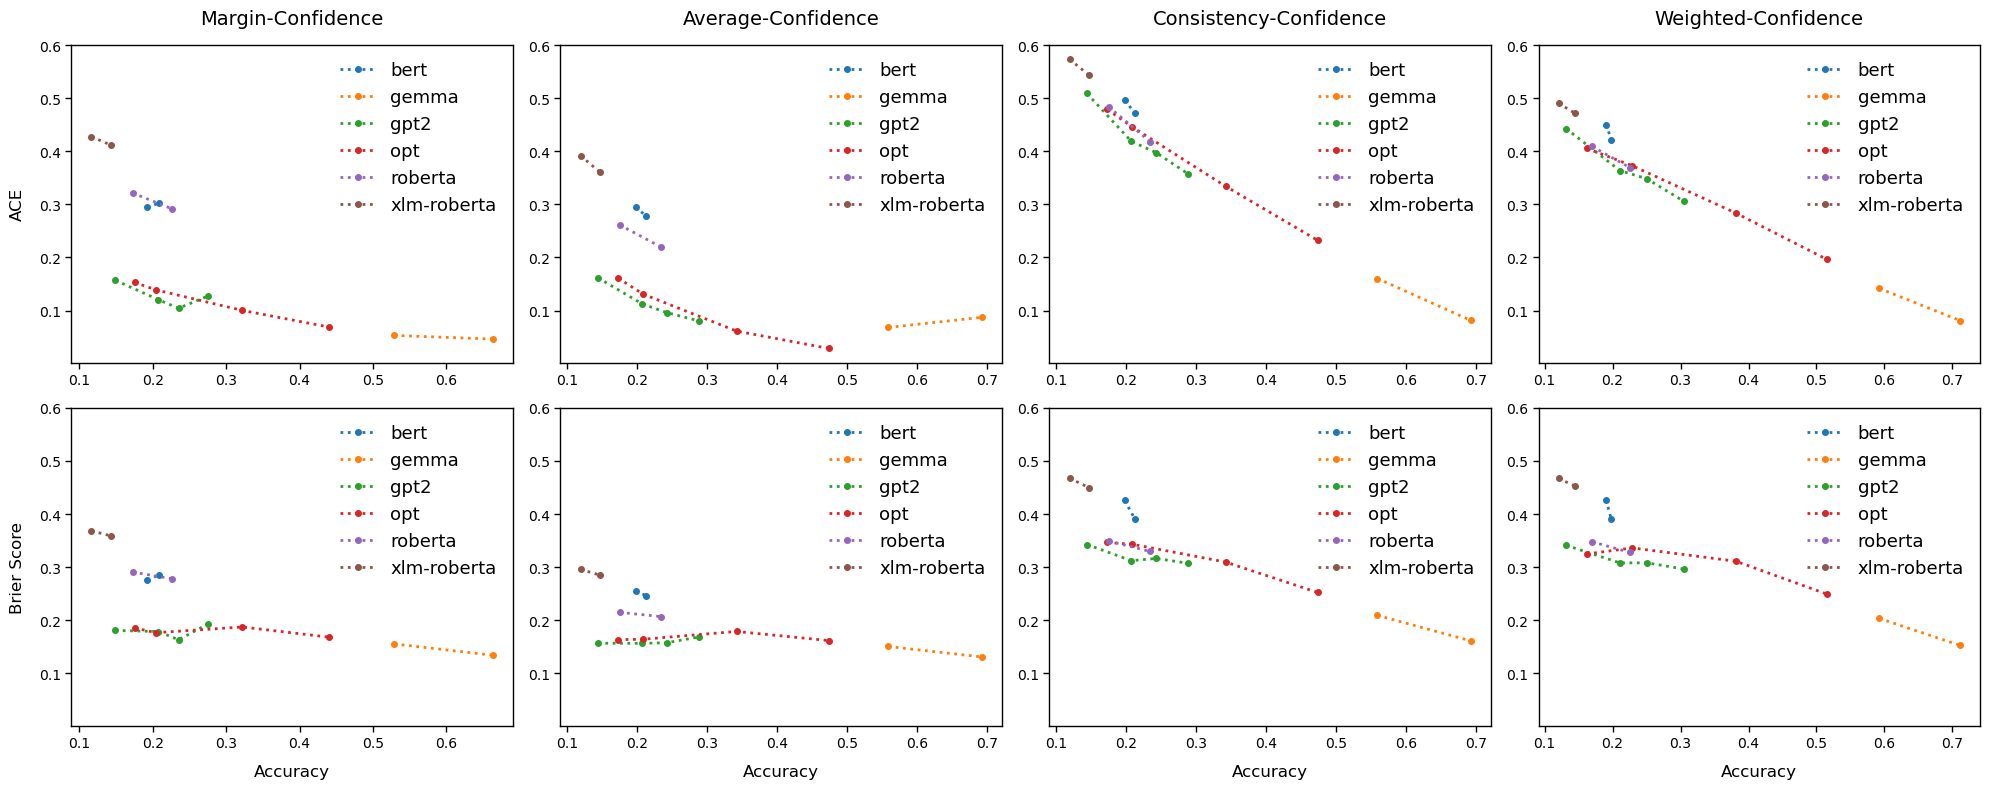

In [10]:
_, axes = plt.subplots(2, 4, figsize=(20, 8), facecolor="white", sharey=True)

plot_accuracy_vs_metric(results_evaluation, metric="ace", estimator="margin_conf",
                        title="Margin-Confidence", axis=axes[0,0])
axes[0,0].set_xlabel("")
axes[0,0].set_ylabel("ACE")
plot_accuracy_vs_metric(results_evaluation, metric="ace", estimator="average_conf_plurality",
                        title="Average-Confidence", axis=axes[0,1])
axes[0,1].set_xlabel("")
axes[0,1].set_ylabel("")
plot_accuracy_vs_metric(results_evaluation, metric="ace", estimator="consistency_conf_plurality",
                        title="Consistency-Confidence", axis=axes[0,2])
axes[0,2].set_xlabel("")
axes[0,2].set_ylabel("")
plot_accuracy_vs_metric(results_evaluation, metric="ace", estimator="weighted_conf",
                        title="Weighted-Confidence", axis=axes[0,3])
axes[0,3].set_xlabel("")
axes[0,3].set_ylabel("")

plot_accuracy_vs_metric(results_evaluation, metric="brier_score",
                        estimator="margin_conf", title="", axis=axes[1,0])
axes[1,0].set_ylabel("Brier Score")
plot_accuracy_vs_metric(results_evaluation, metric="brier_score",
                        estimator="average_conf_plurality", title="", axis=axes[1,1])
axes[1,1].set_ylabel("")
plot_accuracy_vs_metric(results_evaluation, metric="brier_score",
                        estimator="consistency_conf_plurality", title="", axis=axes[1,2])
axes[1,2].set_ylabel("")
plot_accuracy_vs_metric(results_evaluation, metric="brier_score",
                        estimator="weighted_conf", title="", axis=axes[1,3])
axes[1,3].set_ylabel("")

plt.tight_layout()
plt.savefig(graphics_path + "acc_vs_metric" + graphics_format, format="pdf")
plt.show()

### Figure 5.5: Accuracy Rejection Plots

In [11]:
models = ["gpt2-xl", "opt-6.7b", "gemma-7b",
          "bert-large-cased", "roberta-large", "xlm-roberta-large"]
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []

for model in models:
    lm = instance_lvl_results.query("model == @model")
    c_m = np.array(lm.margin_conf)
    p_m = np.array(lm.correctly_predicted)
    c_a = np.array(lm.average_conf_plurality)
    p_a = np.array(lm.plurality_correct)
    
    for t in thresholds:
        # Margin confidence
        selected_m = p_m[c_m >= t]
        rejected_frac_m = 1-len(selected_m)/7731
        rejected_total_m = 7731-len(selected_m)
        true_m = np.sum(selected_m)
        false_m = np.sum(~selected_m)
        frac_true_m = true_m / len(selected_m)
        frac_false_m = false_m / len(selected_m)
        
        # Average confidence
        selected_a = p_a[c_a >= t]
        rejected_frac_a = 1-len(selected_a)/7731
        rejected_total_a = 7731-len(selected_a)
        true_a = np.sum(selected_a)
        false_a = np.sum(~selected_a)
        frac_true_a = true_a / len(selected_a)
        frac_false_a = false_a / len(selected_a)
        
        results.append({
            "model": model,
            "threshold": t,
            "rejected_total_margin": rejected_total_m,
            "rejected_frac_margin": rejected_frac_m,
            "true_margin": true_m,
            "false_margin": false_m,
            "frac_true_margin": frac_true_m,
            "frac_false_margin": frac_false_m,
            "rejected_total_average": rejected_total_a,
            "rejected_frac_average": rejected_frac_a,
            "true_average": true_a,
            "false_average": false_a,
            "frac_true_average": frac_true_a,
            "frac_false_average": frac_false_a
        })
threshold_results = pd.DataFrame(results)

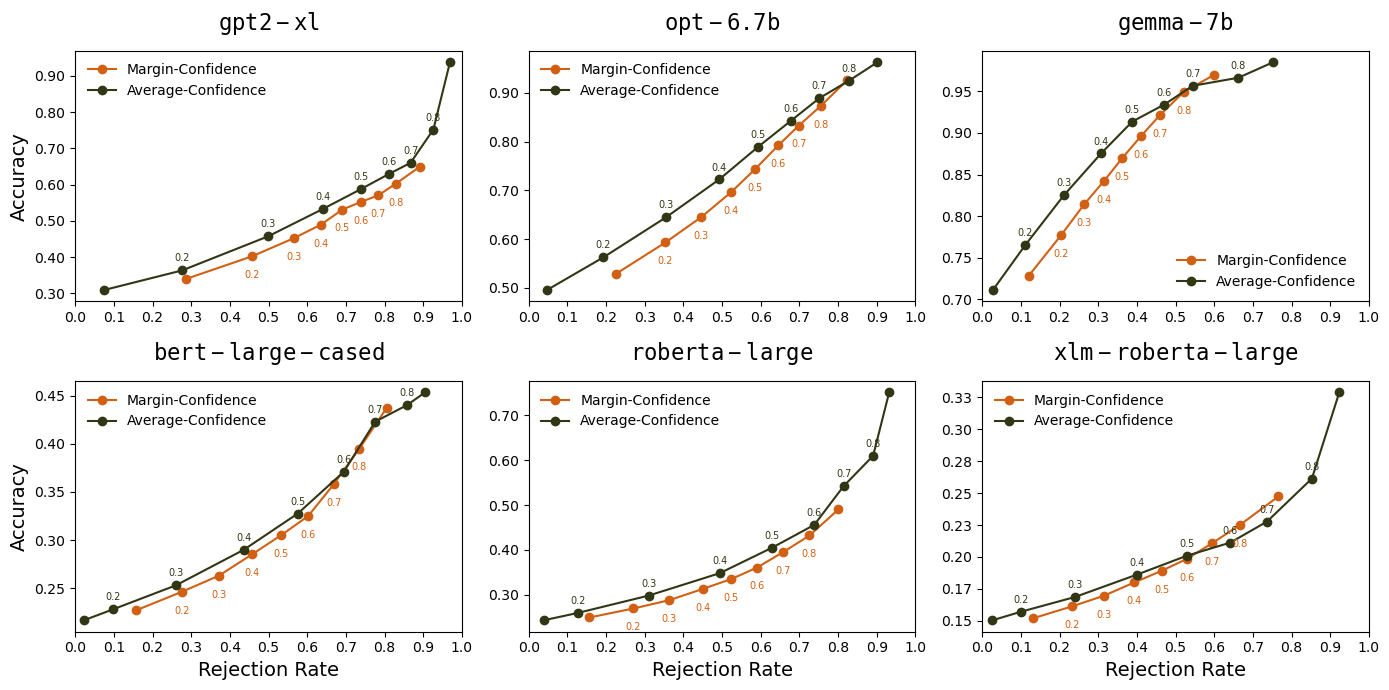

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(14, 7), sharey=False, sharex=False)
axes = axes.flat

for i, model in enumerate(models):
    m = threshold_results.query("model == @model")
    
    # Plot lines
    axes[i].plot(m.rejected_frac_margin, m.frac_true_margin, marker="o", label="Margin-Confidence", color="#d16014")
    axes[i].plot(m.rejected_frac_average, m.frac_true_average, marker="o", label="Average-Confidence", color="#313715")
    
    axes[i].set_title(rf"$\mathtt{{{model}}}$", fontsize=16, pad=15)
    axes[i].legend(frameon=False, fontsize=10, loc="upper left" if model != "gemma-7b" else "lower right")
    axes[i].set_xlim(0, 1)
    axes[i].set_xticks([j/10 for j in range(0, 11)])
    axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}"))
    
    if i >= 3:
        axes[i].set_xlabel("Rejection Rate", fontsize=14)
    if i in [0, 3]:
        axes[i].set_ylabel("Accuracy", fontsize=14)
    
    # Annotate some thresholds for clarity
    for j, t in enumerate(m.threshold):
        if t not in [0.1, 0.9]:  # only annotate selected thresholds
            # Average-Confidence annotation (shift upwards)
            axes[i].annotate(f"{t:.1f}", 
                             xy=(m.rejected_frac_average.iloc[j], m.frac_true_average.iloc[j]),
                             xytext=(0, 5), textcoords="offset points",
                             ha="center", va="bottom", color="#313715", fontsize=7)
            # Margin-Confidence annotation (shift downwards)
            axes[i].annotate(f"{t:.1f}", 
                             xy=(m.rejected_frac_margin.iloc[j], m.frac_true_margin.iloc[j]),
                             xytext=(0, -10), textcoords="offset points",
                             ha="center", va="top", color="#d16014", fontsize=7)

plt.tight_layout()
plt.savefig(graphics_path + "rejection_vs_accuracy_plot" + graphics_format, format="pdf")
plt.show()

In [13]:
threshold_results.query("model == 'gemma-7b'").query("threshold == 0.9")

,model,threshold,rejected_total_margin,rejected_frac_margin,true_margin,false_margin,frac_true_margin,frac_false_margin,rejected_total_average,rejected_frac_average,true_average,false_average,frac_true_average,frac_false_average
26,gemma-7b,0.9,4640,0.600181,2998,93,0.969913,0.030087,5815,0.752167,1887,29,0.984864,0.015136
